## Python Audio Processing Basics
1. Audio formats
- mp3 : 손실 압축 형식으로, 데이터를 압축하는 과정에서 정보 손실 가능성
- flac : 손실이 적은 압축 형식으로, 원본 데이터를 완벽하게 재구성 가능
- wav : 압축하지 않고 데이터를 저장해 오디오 품질이 좋지만 파일 크기가 큼  
    => CD 오디오 품질의 표준

2. Signal parameters
- 다양한 오디오 신호 매개변수
- number of channels
    - 독립 오디오 채널의 수
    - 보통 1~2개(모노/스테레오)
- sample width 
    - 각 샘플의 byte 수
- framerate / sample_rate 
    - 프레임 속도(=샘플 속도, 샘플 주파수)
    - 초당 샘플 수
    - ex) 일반적으로 CD 품질의 표준 샘플링 속도는 44,100 Hz(=44.1kHz)
- number of frames
    - 총 프레임 수
- value of a frame
    - 각 프레임의 값
    - 로드하면 바이너리 형식이고, 나중에 정수 값으로 변환 가능



**(VS Code의 extension에서 audio-preview 다운로드 후 파일을 재생하면 매개변수를 확인할 수 있다)**

In [1]:
import wave

american = wave.open('american.wav', 'rb')    #read binary

print(f'Number of channels : {american.getnchannels()}')    #1 : 모노채널
print(f'Sample width : {american.getsampwidth()}')          #2 : 각 샘플은 2byte
print(f'Frame rate : {american.getframerate()}')            #8000 : 1초에 샘플 8000개
print(f'Number of frames : {american.getnframes()}')        #268985 : 총 샘플 수
print()
print(f'Parameters : {american.getparams()}')

Number of channels : 1
Sample width : 2
Frame rate : 8000
Number of frames : 268985

Parameters : _wave_params(nchannels=1, sampwidth=2, framerate=8000, nframes=268985, comptype='NONE', compname='not compressed')


In [2]:
len_audio = american.getnframes() / american.getframerate()

print(len_audio)

33.623125


In [3]:
frames = american.readframes(-1)    #전체 프레임 읽기

print(type(frames), type(frames[0]))
print(int(len(frames) / 2))    #각 샘플이 2byte => frames = 총 샘플 수 268985 * 2 = 537970 => 2로 나눠서 맞춰줌

american.close()    #객체 닫기

<class 'bytes'> <class 'int'>
268985


3. Wave module
    - wav 모듈을 사용하여 WAV 파일을 로드, 저장하는 방법

In [4]:
new_american = wave.open('new_american.wav', 'wb')    #write binary

new_american.setnchannels(1)
new_american.setsampwidth(2)
new_american.setframerate(8000)

new_american.writeframes(frames)

new_american.close()

4. Plot waveform
- matplotlib을 이용해 웨이브 시각화

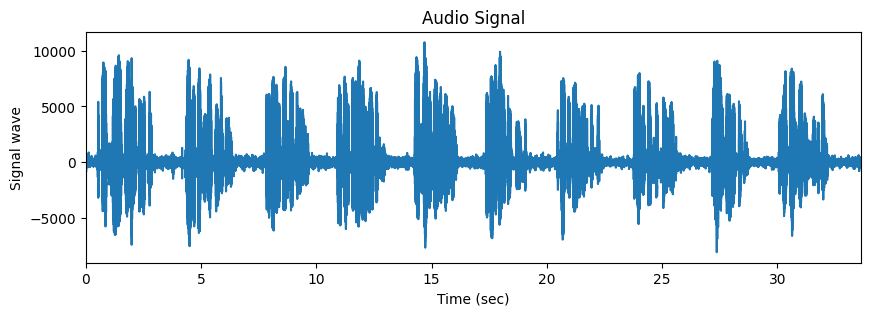

In [5]:
import wave
import matplotlib.pyplot as plt
import numpy as np

american = wave.open('american.wav', 'rb')  

sample_freq = american.getframerate()    #8000
n_samples = american.getnframes()        #268985
signal_wave = american.readframes(-1)

american.close()

len_audio = n_samples / sample_freq
#print(len_audio)

#byte 객체(signal_wave)로부터 numpy array 얻기
signal_array = np.frombuffer(signal_wave, dtype=np.int16)    #Interpret a buffer as a 1-dimensional array

#x축(time) 객체 얻기
times = np.linspace(0, len_audio, n_samples)  

plt.figure(figsize=(10,3))
plt.plot(times, signal_array)
plt.title('Audio Signal')
plt.ylabel('Signal wave')
plt.xlabel('Time (sec)')
plt.xlim(0, len_audio)
plt.show()

5. Microphone recording
- PyAudio : audio I/O library, 음성 파일 재생, 녹음 가능

In [11]:
import pyaudio

#재생 시 파라미터 지정
FRAMES_PER_BUFFER = 3200
FORMAT = pyaudio.paInt16    #위에서 frombuffer 할 때와 같게
CHANNELS = 1
RATE = 8000

p = pyaudio.PyAudio()
stream = p.open(rate=RATE,
                channels=CHANNELS,
                format=FORMAT,
                input=True,
                frames_per_buffer=FRAMES_PER_BUFFER)

print('Start Recording...')

#실행 후 5초간 마이크에 입력되는 소리를 녹음
sec = 5   
frames = []
for i in range(0, int(RATE/FRAMES_PER_BUFFER*sec)):
    data = stream.read(FRAMES_PER_BUFFER)
    frames.append(data)
    
stream.stop_stream()
stream.close()
p.terminate()

#녹음된 결과물 저장
result = wave.open('my_record_5s.wav', 'wb')
result.setnchannels(CHANNELS)
result.setsampwidth(p.get_sample_size(FORMAT))
result.setframerate(RATE)

result.writeframes(b''.join(frames))
result.close()

Start Recording...


6. Load mp3
- Pydub 라이브러리 사용
    - 간단하고 쉬운 고수준 인터페이스로 오디오 조작 가능
    - ffmpeg, avlib 도 함께 설치 필요
    - ffmpeg : https://www.gyan.dev/ffmpeg/builds 에서 다운로드 가능
        - 압축해제 한 파일 내 bins 파일의 경로를 환경변수에 추가 => 재부팅 필요
        - cmd에서 `ffmpeg -version` 명령어로 확인 가능

In [12]:
from pydub import AudioSegment

audio = AudioSegment.from_wav('my_record_5s.wav')

audio = audio + 6    # 6dB 더 크게
audio = audio * 2    # 2번 반복
audio = audio.fade_in(2000)    #처음 2000ms(=2초) fade in
audio = audio.fade_out(2000)   #마지막 2000ms fade out

audio.export('mashup.mp3', format='mp3')

<_io.BufferedRandom name='mashup.mp3'>